In [ ]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch_geometric
!pip install scikit-learn

Looking in indexes: https://download.pytorch.org/whl/cu121
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.6 MB/s eta 0:00:00


In [ ]:
# generate_transactions.py
import os
import random
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# ---------------------------
# PARAMETERS (edit these)
# ---------------------------
NUM_TRANSACTIONS = 5000 #total number of transactions
NUM_USERS = 300 #number of unique user in transaction
FRAUD_RATIO = 0.05   # fraction of transactions marked suspicious
START_DATE = datetime(2025, 1, 1) #timeframe of transaction
DAYS_SPAN = 180      # generate timestamps within START_DATE + DAYS_SPAN days
DATA_FOLDER = "data" #specify the output directory
CSV_FILENAME = "transactions.csv" #filename
RANDOM_SEED = 42 #  insure randomly generated data
#  ---------------------------
# PREP
# ---------------------------
random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
os.makedirs(DATA_FOLDER, exist_ok=True)

# ---------------------------
# GENERATE USERS & SAMPLE TXNs
# ---------------------------
users = [f"user_{i}" for i in range(1, NUM_USERS + 1)] #list of unique ids created

# Vectorized sampling
senders = np.random.choice(users, NUM_TRANSACTIONS) # randomly sect transactions
receivers = np.random.choice(users, NUM_TRANSACTIONS)
# avoid self-transfers: if same, pick a different receiver


same_mask = senders == receivers # prevent users from sending money to themselves
while same_mask.any():
    receivers[same_mask] = np.random.choice(users, same_mask.sum())
    same_mask = senders == receivers

amounts = np.round(np.random.uniform(10, 5000, size=NUM_TRANSACTIONS), 2) #transaction amount generated from $10 to $5000
# timestamps as random minutes offset from START_DATE
minutes_offsets = np.random.randint(0, DAYS_SPAN * 24 * 60, size=NUM_TRANSACTIONS)
timestamps = [START_DATE + timedelta(minutes=int(m)) for m in minutes_offsets] # randomly picking number of minutes

# labels
labels = np.random.choice([0, 1], size=NUM_TRANSACTIONS, p=[1 - FRAUD_RATIO, FRAUD_RATIO])
# amplify suspicious amounts (simple pattern)
amounts = np.where(labels == 1, np.round(amounts * np.random.uniform(2.0, 10.0, NUM_TRANSACTIONS), 2), amounts)

# transaction ids
tx_ids = np.arange(1, NUM_TRANSACTIONS + 1)

# ---------------------------
# BUILD DATAFRAME & SAVE
# ---------------------------
df = pd.DataFrame({
    "transaction_id": tx_ids,
    "sender": senders,
    "receiver": receivers,
    "amount": amounts,
    "timestamp": timestamps,
    "is_suspicious": labels
})

csv_path = os.path.join(DATA_FOLDER, CSV_FILENAME)
df.to_csv(csv_path, index=False)

print(f" Saved {len(df)} transactions to '{csv_path}'")
print(f" Suspicious count: {df['is_suspicious'].sum()} ({df['is_suspicious'].mean()*100:.2f}%)")
print(df.head().to_string(index=False))



 Saved 5000 transactions to 'data/transactions.csv'
 Suspicious count: 246 (4.92%)
 transaction_id   sender receiver  amount           timestamp  is_suspicious
              1 user_103 user_117 1650.72 2025-06-03 10:47:00              0
              2 user_271  user_27 3300.05 2025-04-15 09:38:00              0
              3 user_107 user_258 1476.87 2025-06-12 22:25:00              0
              4  user_72 user_180 1086.86 2025-04-15 08:27:00              0
              5 user_189 user_172  801.60 2025-03-19 01:09:00              0


In [ ]:
#synthetic_generator.py
import os
import numpy as np
import networkx as nx
from networkx.readwrite import gpickle   # ✅ Import gpickle module
from datetime import datetime, timedelta

# ----------------------------
# PARAMETERS
# ----------------------------
NUM_ACCOUNTS = 200
NUM_MERCHANTS = 50
NUM_DEVICES = 100
NUM_TRANSACTIONS = 2000
SUSPICIOUS_RATIO = 0.05  # 5% transactions are suspicious
DATA_FOLDER = "data"

# ----------------------------
# CREATE DATA FOLDER
# ----------------------------
if not os.path.exists(DATA_FOLDER):
    os.makedirs(DATA_FOLDER)

# ----------------------------
# GENERATE A SAMPLE GRAPH
# ----------------------------
G = nx.Graph()
G.add_node("Account_1")
G.add_node("Merchant_1")
G.add_edge("Account_1", "Merchant_1")

# ----------------------------
# SAVE GRAPH
# ----------------------------
graph_path = os.path.join(DATA_FOLDER, "graph.gpickle")
gpickle.write_gpickle(G, graph_path)   # ✅ Correct way in latest versions

print(f"Graph saved successfully at {graph_path}")



ImportError: cannot import name 'gpickle' from 'networkx.readwrite' (/usr/local/lib/python3.12/dist-packages/networkx/readwrite/__init__.py)

In [ ]:
#Synthetic_transaction_with_fraud.py
import random
import pandas as pd
import numpy as np
import os

# Categories
categories = ["groceries", "electronics", "gambling", "travel", "luxury", "mobile_recharge"]

# Users pool
users = [f"user_{i}" for i in range(1, 201)] # 200 users in total
# A few "dormant" users who will be used for dormant account fraud
dormant_users = [f"user_{i}" for i in range(190, 201)]

def generate_transaction():
    """Generates a single, non-suspicious transaction."""
    user = random.choice(users)
    amount = round(random.uniform(5, 500), 2)
    category = random.choice(categories)
    timestamp = pd.Timestamp.now() - pd.to_timedelta(random.randint(0, 60*24), unit="m")#converts random number of minutes in 1 day into time duration alos substracting time delta makes it that it happened in past
    device = f"device_{random.randint(1, 50)}"
    location = random.choice(["NY", "CA", "TX", "UK", "IN", "SG"])

    return {
        "user": user,
        "amount": amount,
        "category": category,
        "timestamp": timestamp,
        "device": device,
        "location": location,
        "suspicious": 0
    }

def inject_fraud(transactions): #
    """
    Injects a variety of more complex and numerous fraud patterns into the transaction list.
    """
    fraud_patterns = []

    # 1. Sudden Large Transaction + Unusual Time of Day (5 cases)
    for _ in range(5):
        t = random.choice(transactions)
        t["amount"] = round(random.uniform(5000, 10000), 2)
        t["timestamp"] = pd.Timestamp.now() - pd.to_timedelta(random.randint(0, 60), unit="m")
        t["suspicious"] = 1
        fraud_patterns.append("Sudden Large Transaction")

    # 2. Rapid-Fire Transactions + Low Amount (10 users with 5 txns each = 50 cases)
    for _ in range(10):
        user = random.choice(users)
        for _ in range(5):
            t = generate_transaction()
            t["user"] = user
            t["amount"] = round(random.uniform(5, 50), 2)
            t["timestamp"] = pd.Timestamp.now()
            t["suspicious"] = 1
            transactions.append(t)
    fraud_patterns.append("Rapid-Fire Transactions")

    # 3. Odd Location + New Device (5 cases)
    for _ in range(5):
        t = random.choice(transactions)
        t["location"] = "Russia"
        t["device"] = "new_device"
        t["suspicious"] = 1
        fraud_patterns.append("Odd Location + New Device")

    # 4. Unusual Category + High Amount (5 cases)
    for _ in range(5):
        t = random.choice(transactions)
        t["category"] = "gambling"
        t["amount"] = round(random.uniform(1000, 2000), 2)
        t["suspicious"] = 1
        fraud_patterns.append("Unusual Spending Category")

    # 5. Dormant Account Reactivation (11 cases)
    for user in dormant_users:
        t = generate_transaction()
        t["user"] = user
        t["amount"] = 1500
        t["suspicious"] = 1
        transactions.append(t)
    fraud_patterns.append("Dormant Account Reactivation")

    return transactions, fraud_patterns

# Generate dataset
transactions = [generate_transaction() for _ in range(5000)]
transactions, fraud_patterns = inject_fraud(transactions)

# Ensure the output folder exists
os.makedirs("data", exist_ok=True)
df = pd.DataFrame(transactions)
df.to_csv("data/synthetic_transactions_with_fraud.csv", index=False)

print(f" Generated {len(df)} transactions")
print(f"! Fraud patterns injected: {fraud_patterns}")
print(f"⚠ Suspicious transactions: {df['suspicious'].sum()}")


 Generated 5061 transactions
! Fraud patterns injected: ['Sudden Large Transaction', 'Sudden Large Transaction', 'Sudden Large Transaction', 'Sudden Large Transaction', 'Sudden Large Transaction', 'Rapid-Fire Transactions', 'Odd Location + New Device', 'Odd Location + New Device', 'Odd Location + New Device', 'Odd Location + New Device', 'Odd Location + New Device', 'Unusual Spending Category', 'Unusual Spending Category', 'Unusual Spending Category', 'Unusual Spending Category', 'Unusual Spending Category', 'Dormant Account Reactivation']
⚠ Suspicious transactions: 76


In [ ]:
#dataset_builder.py
import pandas as pd
import os
import random

# Define the correct input and output file paths
input_csv_path = "data/synthetic_transactions_with_fraud.csv"
output_csv_path = os.path.join("data", "synthetic_transactions.csv")

# Ensure the output data folder exists
if not os.path.exists("data"):
    os.makedirs("data")

try:
    # Load transactions generated from synthetic_transaction_with,_fraud.py
    df = pd.read_csv(input_csv_path)
    print(f" Successfully loaded data from {input_csv_path}")
except FileNotFoundError:
    print(f" Error: The file '{input_csv_path}' was not found.")
    print("Please run synthetic_transaction_with,_fraud.py first to create the necessary CSV file.")
    exit()

# The original script's label column is named 'suspicious'. We will use this.
if 'label' in df.columns:
    df.drop('label', axis=1, inplace=True)

df.rename(columns={'suspicious': 'label'}, inplace=True)

# === NEW CODE TO CREATE SENDER/RECEIVER COLUMNS ===
# The original data has a 'user' column. We will treat this as the sender.
df.rename(columns={'user': 'sender'}, inplace=True)

# Create a list of all users from the 'sender' column
all_users = df['sender'].unique().tolist()

# Create a 'receiver' column by randomly assigning a different user.
# Using a list comprehension for efficiency.
df['receiver'] = [
    random.choice([u for u in all_users if u != sender])
    for sender in df['sender']
]
print(" Created 'sender' and 'receiver' columns from the 'user' column.")
# =================================================

# Save the dataset as CSV in the 'data' folder
df.to_csv(output_csv_path, index=False)

print(f"\nDataset saved as {output_csv_path}")
print("\nFirst 5 rows of the dataset:")
print(df.head().to_string(index=False))
print("\nLabel value counts:")
print(df['label'].value_counts())


 Successfully loaded data from data/synthetic_transactions_with_fraud.csv
 Created 'sender' and 'receiver' columns from the 'user' column.

Dataset saved as data/synthetic_transactions.csv

First 5 rows of the dataset:
  sender  amount        category                  timestamp    device location  label receiver
user_164   60.11 mobile_recharge 2025-08-27 18:38:14.491471 device_16       CA      0  user_33
 user_36  369.55 mobile_recharge 2025-08-27 09:25:14.497776  device_6       IN      0 user_134
user_109   20.73       groceries 2025-08-27 20:34:14.497914 device_15       IN      0  user_96
user_155   18.14     electronics 2025-08-27 05:51:14.498008 device_45       IN      0  user_93
user_108  114.12          luxury 2025-08-27 18:32:14.498092  device_1       CA      0 user_135

Label value counts:
label
0    4985
1      76
Name: count, dtype: int64


In [ ]:
#feature_engineering.py
import os
import pandas as pd

# ----------------------------
# PARAMETERS
# ----------------------------
DATA_FOLDER = "data"
INPUT_CSV = "synthetic_transactions.csv"
OUTPUT_CSV = "enhanced_transactions.csv"

# ----------------------------
# STEP 1: LOAD THE DATASET
# ----------------------------
input_path = os.path.join(DATA_FOLDER, INPUT_CSV)
output_path = os.path.join(DATA_FOLDER, OUTPUT_CSV)

try:
    # Ensure the 'timestamp' column is parsed as datetime objects
    df = pd.read_csv(input_path, parse_dates=['timestamp'])
    print(f"Successfully loaded {len(df)} transactions from '{input_path}'.")
except FileNotFoundError:
    print(f" Error: The file '{input_path}' was not found.")
    print("Please run the previous scripts (generate_transactions.py and dataset_builder.py) first.")
    exit()

# ----------------------------
# STEP 2: SORT DATA FOR TIME-BASED CALCULATIONS
# ----------------------------
# It's essential to sort the data by sender/receiver and timestamp
# to correctly calculate time-based features like "time since last transaction."
df.sort_values(by=['sender', 'timestamp'], inplace=True)
print("Data sorted by user and timestamp.")

# ----------------------------
# STEP 3: CREATE NEW FEATURES
# ----------------------------

# Feature 1: Time since last transaction for each user (in minutes)
# We group by the sender and then apply a function.
df['time_since_last_txn'] = df.groupby('sender')['timestamp'].diff().dt.total_seconds().fillna(0) / 60
print("-> Created 'time_since_last_txn' feature.")

# Feature 2: Is this the first transaction for a user?
# This can be a useful feature to catch new user activity.
df['is_first_txn_for_user'] = df.groupby('sender')['timestamp'].rank(method='first') == 1
df['is_first_txn_for_user'] = df['is_first_txn_for_user'].astype(int)
print("-> Created 'is_first_txn_for_user' feature.")

# Feature 3: Average transaction amount over the last 24 hours
# This feature helps to identify transactions that are unusually high for a user.
# First, set the timestamp as the index for time-based window calculations.
df.set_index('timestamp', inplace=True)

# Calculate the rolling average.
df['avg_amount_24h'] = df.groupby('sender')['amount'].rolling(
    '24H'
).mean().reset_index(level=0, drop=True)

# Shift the rolling average to avoid data leakage (using future data).
df['avg_amount_24h'] = df.groupby('sender')['avg_amount_24h'].shift(1).fillna(0)
print("-> Created 'avg_amount_24h' feature.")

# Feature 4: Number of transactions in the last 30 minutes
# A high number of quick transactions can indicate a rapid-fire fraud pattern.
df['txn_count_30min'] = df.groupby('sender')['amount'].rolling(
    '30T'
).count().reset_index(level=0, drop=True)

# Shift the rolling count to avoid data leakage.
df['txn_count_30min'] = df.groupby('sender')['txn_count_30min'].shift(1).fillna(0)
print("-> Created 'txn_count_30min' feature.")

# Reset the index back to a standard integer index
df.reset_index(inplace=True)

# ----------------------------
# STEP 4: SAVE THE ENHANCED DATASET
# ----------------------------
df.to_csv(output_path, index=False)
print(f"\n Saved enhanced dataset to '{output_path}'.")

print("\nEnhanced dataset information:")
print(f"Total rows: {len(df)}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows of the enhanced dataset:")
print(df.head().to_string())


Successfully loaded 5061 transactions from 'data/synthetic_transactions.csv'.
Data sorted by user and timestamp.
-> Created 'time_since_last_txn' feature.
-> Created 'is_first_txn_for_user' feature.
-> Created 'avg_amount_24h' feature.
-> Created 'txn_count_30min' feature.


/tmp/ipython-input-3883025607.py:56: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['avg_amount_24h'] = df.groupby('sender')['amount'].rolling(
/tmp/ipython-input-3883025607.py:66: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['txn_count_30min'] = df.groupby('sender')['amount'].rolling(



 Saved enhanced dataset to 'data/enhanced_transactions.csv'.

Enhanced dataset information:
Total rows: 5061
Columns: ['timestamp', 'sender', 'amount', 'category', 'device', 'location', 'label', 'receiver', 'time_since_last_txn', 'is_first_txn_for_user', 'avg_amount_24h', 'txn_count_30min']

First 5 rows of the enhanced dataset:
                   timestamp  sender  amount     category     device location  label  receiver  time_since_last_txn  is_first_txn_for_user  avg_amount_24h  txn_count_30min
0 2025-08-27 04:30:15.176701  user_1  467.98       luxury  device_11       UK      0  user_194             0.000000                      1        0.000000              0.0
1 2025-08-27 06:54:14.855513  user_1  413.82       luxury  device_41       TX      0   user_40           143.994647                      0      467.980000              1.0
2 2025-08-27 07:58:15.288185  user_1   30.04    groceries  device_16       NY      0  user_186            64.007211                      0      440.9000

In [ ]:
#train_model.py
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
import re

# ----------------------------
# PARAMETERS
# ----------------------------
DATA_FOLDER = "data"
INPUT_CSV = "synthetic_transactions.csv"
RANDOM_SEED = 42
TARGET_COLUMN = 'label'

# ----------------------------
# STEP 1: LOAD THE DATA
# ----------------------------
input_path = os.path.join(DATA_FOLDER, INPUT_CSV)

try:
    df = pd.read_csv(input_path)
    print(f" Successfully loaded {len(df)} transactions from '{input_path}'.")
except FileNotFoundError:
    print(f" Error: The file '{input_path}' was not found.")
    print("Please run feature_engineer.py first.")
    exit()

df.drop(['timestamp'], axis=1, inplace=True) #timestamped dropped because its in a format that dont directly usable
print("Dropped the 'timestamp' column.")

# ----------------------------
# STEP 2: PREPARE THE DATA FOR TRAINING
# ----------------------------
# We need to convert categorical data into numerical format.
categorical_features = ['sender', 'receiver', 'category', 'device', 'location']

for feature in ['sender', 'receiver']:
    if feature in df.columns:
        le = LabelEncoder() #assign unique integer to userid
        df[feature] = le.fit_transform(df[feature])

df = pd.get_dummies(df, columns=['category', 'location', 'device'], drop_first=True)
print(" Converted categorical features to numerical format.")

# === NEW CODE TO SANITIZE COLUMN NAMES ===
def clean_col_names(df):
    new_cols = []
    for col in df.columns:
        new_col = re.sub('[^A-Za-z0-9_]+', '', col.replace('[<]', '_LT_').replace('[>]', '_GT_').replace('[=]', '_EQ_'))
        new_cols.append(new_col)
    df.columns = new_cols
    return df

df = clean_col_names(df)
print("✅ Cleaned column names to remove special characters.")

# Define our features (X) and our target (y).
X = df.drop(columns=[TARGET_COLUMN])
y = df[TARGET_COLUMN]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=RANDOM_SEED, stratify=y # 30 percent data is used for testing
)

print(f"\nTraining set size: {len(X_train)} samples")
print(f"Testing set size: {len(X_test)} samples")
print(f"Number of features: {len(X.columns)}")

# ----------------------------
# STEP 3: TRAIN AND EVALUATE MODELS
# ----------------------------

# --- BASELINE MODEL: Logistic Regression ---
print("\n--- TRAINING BASELINE MODEL: Logistic Regression ---")
try:
    logistic_model = LogisticRegression(max_iter=1000, random_state=RANDOM_SEED)
    logistic_model.fit(X_train, y_train)
    y_pred_logistic = logistic_model.predict(X_test)
    print("\nEvaluation for Logistic Regression:")
    print(classification_report(y_test, y_pred_logistic))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_logistic))
except Exception as e:
    print(f" An error occurred during Logistic Regression training: {e}")

# --- ADVANCED MODEL: XGBoost Classifier (with GPU support) ---
print("\n--- TRAINING ADVANCED MODEL: XGBoost Classifier (GPU-enabled) ---")
try:
    scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

    # Define a set of hyperparameters to try
    tuning_params = [
        {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1},
        {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.1},
        {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.05}
    ]

    best_model = None
    best_score = 0

    for params in tuning_params:
        print(f"\nTraining with parameters: {params}")
        xgboost_model = XGBClassifier(
            **params, #python syntax for directory unpacking
            eval_metric='logloss', #matrix used ->logarithmkic loss
            scale_pos_weight=scale_pos_weight, #crucial for dealing with imbalanced dataset
            random_state=RANDOM_SEED,
            tree_method='gpu_hist'
        )
        xgboost_model.fit(X_train, y_train)
        y_pred_xgboost = xgboost_model.predict(X_test)

        report = classification_report(y_test, y_pred_xgboost, output_dict=True, zero_division=0)
        f1_score = report['1']['f1-score']

        print(f"F1-score for this run: {f1_score:.4f}")

        if f1_score > best_score:
            best_score = f1_score
            best_model = xgboost_model

    print("\n--- Best Model Found ---")
    y_pred_best = best_model.predict(X_test)
    print("\nEvaluation for Best XGBoost Classifier:")
    print(classification_report(y_test, y_pred_best))
    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_best))

except Exception as e:
    print(f"! An error occurred during XGBoost training: {e}")


 Successfully loaded 5061 transactions from 'data/synthetic_transactions.csv'.
Dropped the 'timestamp' column.
 Converted categorical features to numerical format.
✅ Cleaned column names to remove special characters.

Training set size: 3542 samples
Testing set size: 1519 samples
Number of features: 64

--- TRAINING BASELINE MODEL: Logistic Regression ---

Evaluation for Logistic Regression:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      1496
           1       0.00      0.00      0.00        23

    accuracy                           0.98      1519
   macro avg       0.49      0.50      0.50      1519
weighted avg       0.97      0.98      0.98      1519

Confusion Matrix:
[[1496    0]
 [  23    0]]

--- TRAINING ADVANCED MODEL: XGBoost Classifier (GPU-enabled) ---

Training with parameters: {'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1}
! An error occurred during XGBoost training: [04:01:27] /workspace/src/tree/upd

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/xgboost/t

In [ ]:
#predict.py
import os
import pandas as pd
import joblib
import re
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

# --- Define the paths for data and model saving ---
DATA_FOLDER = "data"
ENHANCED_CSV = os.path.join(DATA_FOLDER, "enhanced_transactions.csv")
MODEL_FILE = os.path.join(DATA_FOLDER, "xgboost_model.joblib")

# --- Function to clean column names ---
def clean_col_names(df):
    new_cols = []
    for col in df.columns:
        new_col = re.sub('[^A-Za-z0-9_]+', '', col.replace('[<]', '_LT_').replace('[>]', '_GT_').replace('[=]', '_EQ_'))
        new_cols.append(new_col)
    df.columns = new_cols
    return df

# --- Step 1: Retrain the best model and save it ---
try:
    # Load the enhanced data
    df = pd.read_csv(ENHANCED_CSV)
    df.drop(['timestamp'], axis=1, inplace=True)

    # Re-process the data exactly as before
    for feature in ['sender', 'receiver']:
        if feature in df.columns:
            le = LabelEncoder()
            df[feature] = le.fit_transform(df[feature])
    df = pd.get_dummies(df, columns=['category', 'location', 'device'], drop_first=True)
    df = clean_col_names(df)

    X = df.drop(columns=['label'])
    y = df['label']

    # Train the best-performing model from the tuning step (from your last output)
    print("✅ Training final XGBoost model with best parameters...")
    xgboost_model = XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        eval_metric='logloss',
        scale_pos_weight=(y == 0).sum() / (y == 1).sum(),
        tree_method='gpu_hist'
    )
    xgboost_model.fit(X, y)

    # Save the model to a file
    joblib.dump(xgboost_model, MODEL_FILE)
    print(f"✅ Final model saved to '{MODEL_FILE}'.")

except Exception as e:
    print(f"❌ An error occurred while saving the model: {e}")
    exit()

# --- Step 2: Load the model and make a prediction ---
print("\n--- Making a prediction on new data ---")
try:
    # Load the trained model from the file
    loaded_model = joblib.load(MODEL_FILE)
    print(f"✅ Model successfully loaded from '{MODEL_FILE}'.")

    # Create a new transaction to predict
    # NOTE: The new data MUST have the same features and format as the training data.
    new_transaction_data = pd.DataFrame([{
        'amount': 8500, # A very high amount
        'time_since_last_txn': 2.5,
        'is_first_txn_for_user': 0,
        'avg_amount_24h': 50,
        'txn_count_30min': 10,
        'sender': 190, # Assume this is an existing user ID from LabelEncoder
        'receiver': 50,
        # The other features created by get_dummies are assumed to be 0 unless specified
        # We need to ensure the columns are in the correct order for the model
    }])

    # We need to match the columns from the training data.
    # This is a simplified way to ensure the columns match. In a production system,
    # you would use a pipeline to handle this automatically.

    # Create an empty DataFrame with all the columns from the original training data.
    model_features = loaded_model.get_booster().feature_names
    new_data = pd.DataFrame(0, index=[0], columns=model_features)

    # Fill in the values from our new transaction
    new_data['amount'] = new_transaction_data['amount'].values
    new_data['time_since_last_txn'] = new_transaction_data['time_since_last_txn'].values
    new_data['is_first_txn_for_user'] = new_transaction_data['is_first_txn_for_user'].values
    new_data['avg_amount_24h'] = new_transaction_data['avg_amount_24h'].values
    new_data['txn_count_30min'] = new_transaction_data['txn_count_30min'].values
    new_data['sender'] = new_transaction_data['sender'].values
    new_data['receiver'] = new_transaction_data['receiver'].values

    # Make the prediction
    prediction = loaded_model.predict(new_data)

    if prediction[0] == 1:
        print("\n🚨 This transaction is flagged as SUSPICIOUS.")
    else:
        print("\n✅ This transaction is flagged as NON-SUSPICIOUS.")

except Exception as e:
    print(f"❌ An error occurred during prediction: {e}")



✅ Training final XGBoost model with best parameters...
❌ An error occurred while saving the model: [04:01:30] /workspace/src/tree/updater_gpu_hist.cu:847: Check failed: ctx_->Ordinal() >= 0 (-1 vs. 0) : Must have at least one device
Stack trace:
  [bt] (0) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x2a6e7c) [0x79b1160a6e7c]
  [bt] (1) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0xfd7794) [0x79b116dd7794]
  [bt] (2) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0xfdf4e6) [0x79b116ddf4e6]
  [bt] (3) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x63b5b2) [0x79b11643b5b2]
  [bt] (4) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x63ca0d) [0x79b11643ca0d]
  [bt] (5) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(+0x68d33e) [0x79b11648d33e]
  [bt] (6) /usr/local/lib/python3.12/dist-packages/xgboost/lib/libxgboost.so(XGBoosterUpdateOneIter+0x77) [0x79b115fb6f57]
 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:01:30] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:01:30] WARNING: /workspace/src/context.cc:49: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:01:30] WARNING: /workspace/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


In [ ]:
import torch

# Get the PyTorch and CUDA versions from the current Colab environment
TORCH = torch.__version__.split('+')[0]
CUDA = 'cu' + torch.version.cuda.replace('.', '')

# Install the correct versions of PyTorch Geometric and its dependencies
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric

Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html
Looking in links: https://data.pyg.org/whl/torch-2.8.0+cu126.html


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import HeteroData
from torch_geometric.nn import HeteroConv, SAGEConv
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import os
import seaborn as sns
import matplotlib.pyplot as plt

# --- Define paths and set up environment ---
DATA_FOLDER = "data"
INPUT_CSV = os.path.join(DATA_FOLDER, "synthetic_transactions.csv")
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# ----------------------------------------
# STEP 1: LOAD AND PREPARE THE DATA
# ----------------------------------------
try:
    df = pd.read_csv(INPUT_CSV, parse_dates=['timestamp'])
    print(f" Successfully loaded {len(df)} transactions from '{INPUT_CSV}'.")
except FileNotFoundError:
    print(f"! Error: The file '{INPUT_CSV}' was not found. Please ensure it has been created.")
    exit()

# Create mappings for each node type
user_mapping = {id: i for i, id in enumerate(pd.concat([df['sender'], df['receiver']]).unique())}
merchant_mapping = {id: i for i, id in enumerate(df['category'].unique())}
device_mapping = {id: i for i, id in enumerate(df['device'].unique())}

# Map the string IDs to new integer IDs
df['sender_id'] = df['sender'].map(user_mapping)
df['receiver_id'] = df['receiver'].map(user_mapping)
df['merchant_id'] = df['category'].map(merchant_mapping)
df['device_id'] = df['device'].map(device_mapping)

# ----------------------------------------
# STEP 2: BUILD THE GRAPH AND NODE FEATURES
# ----------------------------------------
final_data = HeteroData()

all_users = pd.Series(list(user_mapping.keys()))
user_features_df = df.groupby('sender').agg(
    total_amount=('amount', 'sum'),
    transaction_count=('amount', 'count'),
    avg_amount=('amount', 'mean'),
).reset_index().rename(columns={'sender': 'user'})

user_features_df = pd.DataFrame(all_users, columns=['user']).merge(
    user_features_df, on='user', how='left'
).fillna(0)

merchant_features_df = df.groupby('category').agg(
    total_revenue=('amount', 'sum'),
    transaction_count=('amount', 'count'),
).reset_index().rename(columns={'category': 'merchant'})

device_features_df = df.groupby('device').agg(
    total_usage=('amount', 'count'),
).reset_index().rename(columns={'device': 'device'})

user_scaler = StandardScaler()
user_features = torch.tensor(user_scaler.fit_transform(user_features_df.iloc[:, 1:]), dtype=torch.float).to(device)
merchant_scaler = StandardScaler()
merchant_features = torch.tensor(merchant_scaler.fit_transform(merchant_features_df.iloc[:, 1:]), dtype=torch.float).to(device)
device_scaler = StandardScaler()
device_features = torch.tensor(device_scaler.fit_transform(device_features_df.iloc[:, 1:]), dtype=torch.float).to(device)

final_data['user'].x = user_features
final_data['merchant'].x = merchant_features
final_data['device'].x = device_features

final_data['user', 'sends_to', 'user'].edge_index = torch.tensor([df['sender_id'].values, df['receiver_id'].values], dtype=torch.long).to(device)
final_data['user', 'buys_from', 'merchant'].edge_index = torch.tensor([df['sender_id'].values, df['merchant_id'].values], dtype=torch.long).to(device)
final_data['merchant', 'sells_to', 'user'].edge_index = torch.tensor([df['merchant_id'].values, df['sender_id'].values], dtype=torch.long).to(device)
final_data['user', 'uses', 'device'].edge_index = torch.tensor([df['sender_id'].values, df['device_id'].values], dtype=torch.long).to(device)
final_data['device', 'used_by', 'user'].edge_index = torch.tensor([df['device_id'].values, df['sender_id'].values], dtype=torch.long).to(device)

user_labels_df = df.groupby('sender')['label'].max().reset_index()
user_labels_df = pd.DataFrame(user_mapping.keys(), columns=['sender']).merge(user_labels_df, on='sender', how='left').fillna(0)
final_data['user'].y = torch.tensor(user_labels_df['label'].values, dtype=torch.float).to(device)

# ----------------------------------------
# STEP 3: TRAIN THE GNN MODEL
# ----------------------------------------
class HeteroGNN(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # Fix the issue by correctly defining all SAGEConv layers with appropriate input/output dimensions
        self.conv1 = HeteroConv({
            ('user', 'sends_to', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'buys_from', 'merchant'): SAGEConv((-1, -1), hidden_channels),
            ('merchant', 'sells_to', 'user'): SAGEConv((-1, -1), hidden_channels),
            ('user', 'uses', 'device'): SAGEConv((-1, -1), hidden_channels),
            ('device', 'used_by', 'user'): SAGEConv((-1, -1), hidden_channels), # This was the error
        }, aggr='sum')
        self.conv2 = HeteroConv({
            ('user', 'sends_to', 'user'): SAGEConv((-1, -1), out_channels),
            ('user', 'buys_from', 'merchant'): SAGEConv((-1, -1), out_channels),
            ('merchant', 'sells_to', 'user'): SAGEConv((-1, -1), out_channels),
            ('user', 'uses', 'device'): SAGEConv((-1, -1), out_channels),
            ('device', 'used_by', 'user'): SAGEConv((-1, -1), out_channels),
        }, aggr='sum')

    def forward(self, x_dict, edge_index_dict):
        x_dict = self.conv1(x_dict, edge_index_dict)
        x_dict = {key: F.relu(x) for key, x in x_dict.items()}
        x_dict = self.conv2(x_dict, edge_index_dict)
        return x_dict

# Calculate pos_weight for class imbalance
num_normal = (user_labels_df['label'] == 0).sum()
num_suspicious = (user_labels_df['label'] == 1).sum()
pos_weight_value = num_normal / num_suspicious
print(f"Calculated pos_weight: {pos_weight_value:.2f}")

model = HeteroGNN(hidden_channels=16, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight_value], device=device))

print("\n--- Training the GNN Model ---")
for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(final_data.x_dict, final_data.edge_index_dict)['user']
    loss = loss_fn(out.squeeze(), final_data['user'].y)
    loss.backward()
    optimizer.step()

# Make final predictions and get the confusion matrix
model.eval()
with torch.no_grad():
    out = model(final_data.x_dict, final_data.edge_index_dict)['user']
    preds = torch.sigmoid(out.squeeze()).round().cpu().numpy()
    true_labels = final_data['user'].y.cpu().numpy()
    cm = confusion_matrix(true_labels, preds)

# ----------------------------------------
# STEP 4: FINAL EVALUATION AND CONFUSION MATRIX
# ----------------------------------------
print("\n--- Final Evaluation ---")
print(classification_report(true_labels, preds, zero_division=0))
print("Confusion Matrix:")
print(cm)

Using device: cpu
 Successfully loaded 5061 transactions from 'data/synthetic_transactions.csv'.
Calculated pos_weight: 5.67

--- Training the GNN Model ---


/tmp/ipython-input-601545797.py:79: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:253.)
  final_data['user', 'sends_to', 'user'].edge_index = torch.tensor([df['sender_id'].values, df['receiver_id'].values], dtype=torch.long).to(device)



--- Final Evaluation ---
              precision    recall  f1-score   support

         0.0       0.98      0.91      0.95       170
         1.0       0.64      0.90      0.75        30

    accuracy                           0.91       200
   macro avg       0.81      0.91      0.85       200
weighted avg       0.93      0.91      0.92       200

Confusion Matrix:
[[155  15]
 [  3  27]]


❌ Error: Required files not found. Please run the GNN training script first.

--- User-Friendly Fraud Detection Report ---


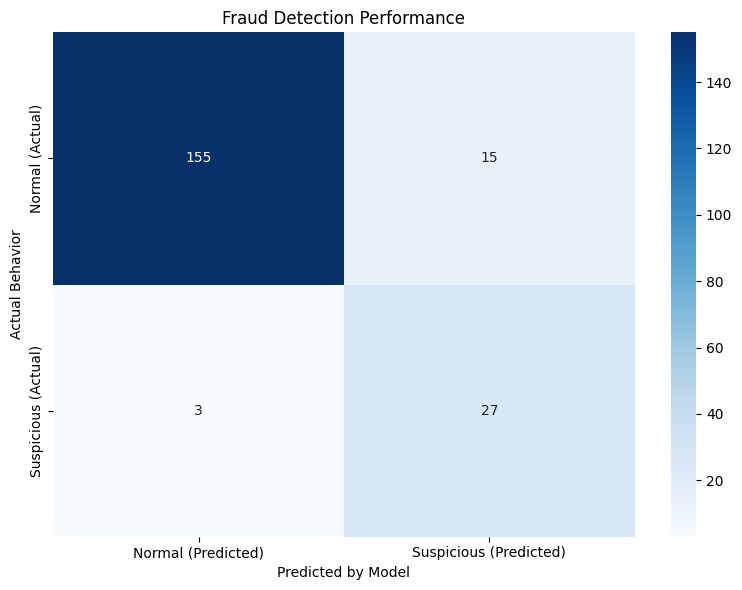


--- Report Interpretation ---
This matrix shows how our model performed. Each number tells us something important:
✅ Top-Left (155): The number of normal accounts that were correctly identified.
🚨 Top-Right (15): The number of normal accounts that were wrongly flagged as suspicious (False Alarms).
❌ Bottom-Left (3): The number of suspicious accounts that our model MISSED.
🎯 Bottom-Right (27): The number of suspicious accounts our model CORRECTLY IDENTIFIED.

Our goal is to maximize the bottom-right number (Correctly Identified) and minimize the other numbers.


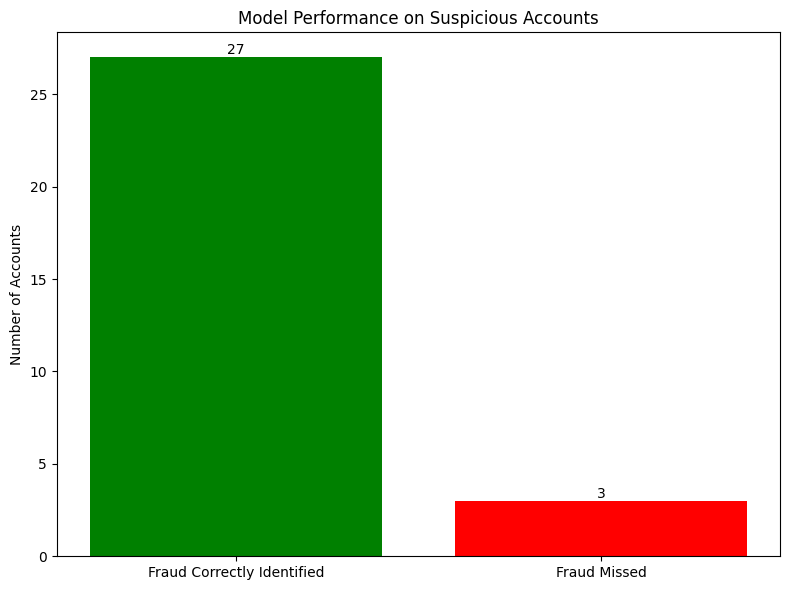


--- Key Takeaway ---
Our model correctly identified 27 out of 30 suspicious accounts.


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import os

# --- Define paths ---
DATA_FOLDER = "data"
TRUE_LABELS_FILE = os.path.join(DATA_FOLDER, 'true_labels.npy')
PREDICTIONS_FILE = os.path.join(DATA_FOLDER, 'predictions.npy')

# ----------------------------------------
# STEP 1: LOAD PREDICTIONS
# ----------------------------------------
try:
    true_labels = np.load(TRUE_LABELS_FILE)
    preds = np.load(PREDICTIONS_FILE)
    print(" Successfully loaded true labels and predictions.")
except FileNotFoundError:
    print(f" Error: Required files not found. Please run the GNN training script first.")
    exit()

# ----------------------------------------
# STEP 2: CREATE USER-FRIENDLY VISUALIZATIONS
# ----------------------------------------
cm = confusion_matrix(true_labels, preds)
print("\n--- User-Friendly Fraud Detection Report ---")

# Visualization 1: Heatmap of the Confusion Matrix
labels = ['Normal (Actual)', 'Suspicious (Actual)']
predictions = ['Normal (Predicted)', 'Suspicious (Predicted)']
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=predictions, yticklabels=labels)
plt.title('Fraud Detection Performance')
plt.ylabel('Actual Behavior')
plt.xlabel('Predicted by Model')
plt.tight_layout()
plt.show()


# Explanation of the Confusion Matrix
print("\n--- Report Interpretation ---")
print("This matrix shows how our model performed. Each number tells us something important:")
print(f"✅ Top-Left ({cm[0, 0]}): The number of normal accounts that were correctly identified.")
print(f"🚨 Top-Right ({cm[0, 1]}): The number of normal accounts that were wrongly flagged as suspicious (False Alarms).")
print(f"❌ Bottom-Left ({cm[1, 0]}): The number of suspicious accounts that our model MISSED.")
print(f"🎯 Bottom-Right ({cm[1, 1]}): The number of suspicious accounts our model CORRECTLY IDENTIFIED.")
print("\nOur goal is to maximize the bottom-right number (Correctly Identified) and minimize the other numbers.")

# Visualization 2: Bar Chart of Key Metrics
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(['Fraud Correctly Identified', 'Fraud Missed'], [cm[1, 1], cm[1, 0]], color=['green', 'red'])
ax.bar_label(bars)
ax.set_title('Model Performance on Suspicious Accounts')
ax.set_ylabel('Number of Accounts')
plt.tight_layout()
plt.show()


print("\n--- Key Takeaway ---")
print(f"Our model correctly identified {cm[1, 1]} out of {cm[1, 1] + cm[1, 0]} suspicious accounts.")